#  Crude Oil Price Prediction:

## Part 2 : Model Building:

In [1]:
#Importing the required libraries for Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
from pandas.plotting import lag_plot
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy import interpolate
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,Holt,ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller,kpss
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout,Flatten
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler

In [2]:
#Importing dataset:
oil = pd.read_excel("Crude.xlsx",header=0,parse_dates=True)
#Renaming Closing Value to Price:
oil.rename(columns={'Closing Value':'Price'},inplace=True)

### Resampling and Interpolation:

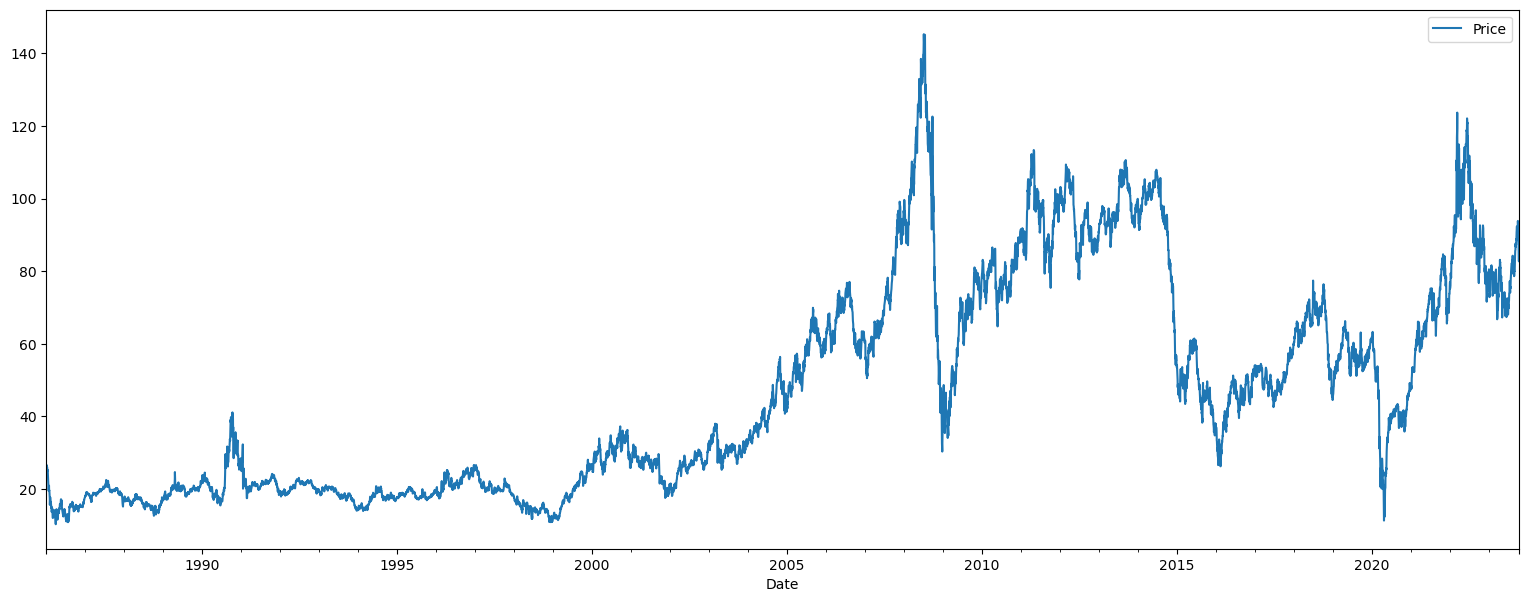

In [3]:
oil.set_index('Date',inplace=True,drop=True) # Resetting Index

oil = oil.resample('D').mean() # Resampling at Daily level

oil = oil.interpolate(method='linear') # Fillling the new null values with mean of previous and next values.
oil.plot(figsize = (19,7))
plt.show() 

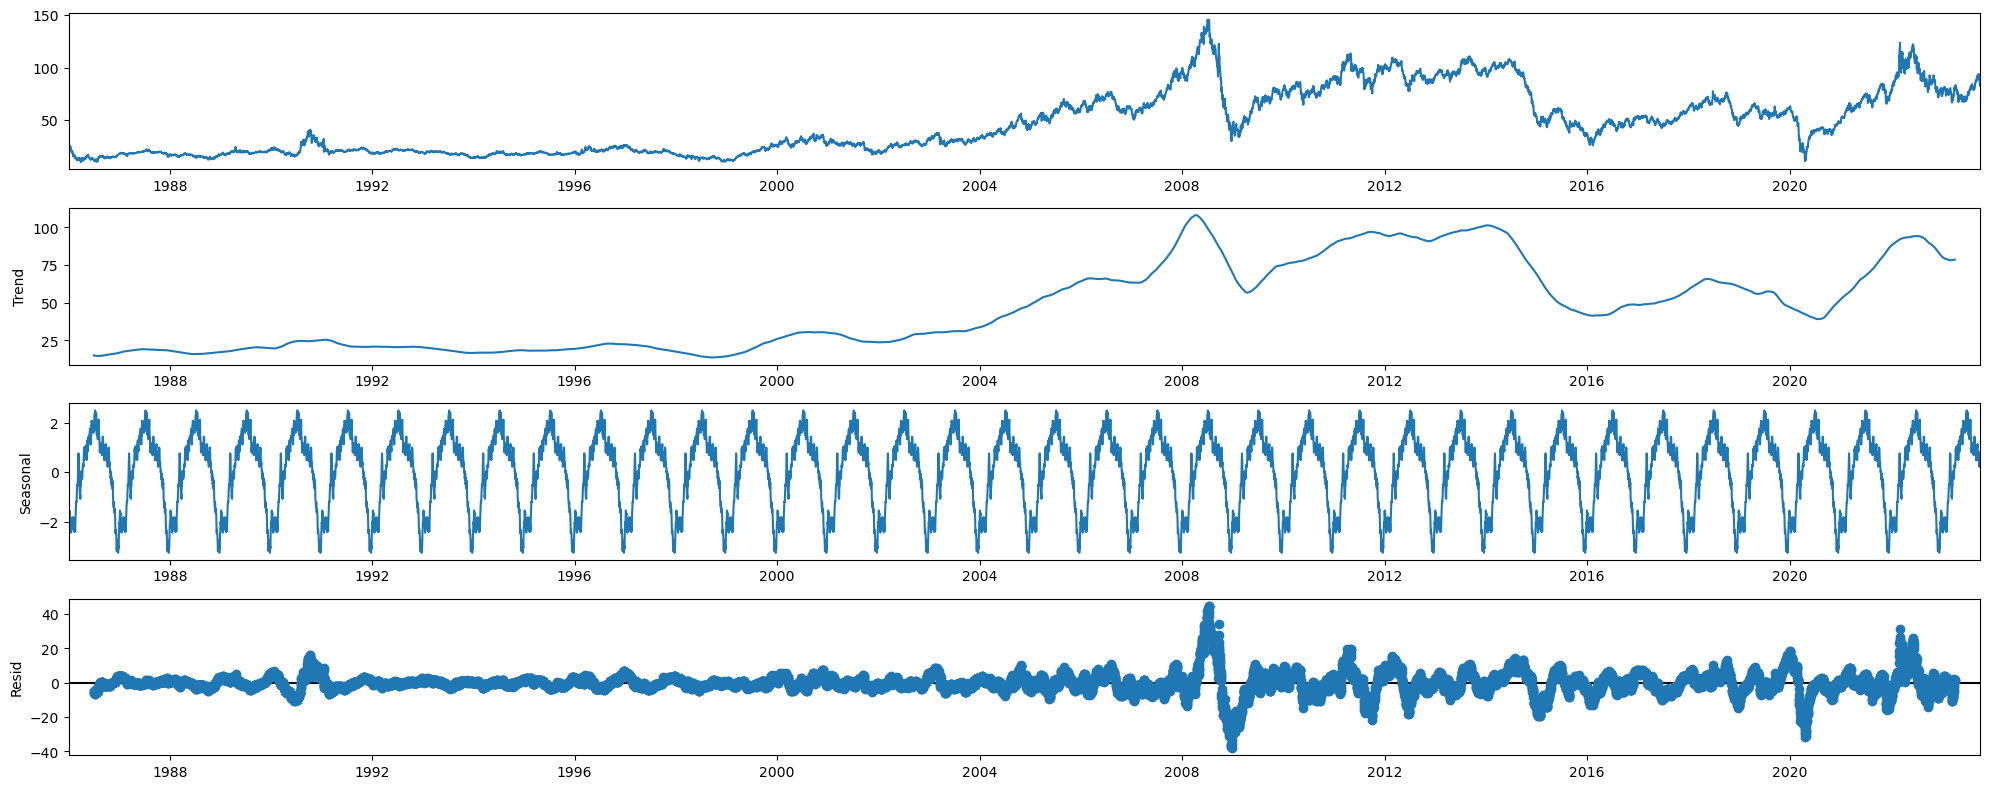

In [4]:
#Seasonal Decompose:
rcParams['figure.figsize'] = (20, 8)
decomposition = seasonal_decompose(oil, model='additive',period=365)
fig = decomposition.plot()
plt.show()

#### Inferences :

In [5]:
# Preparing oil df for modeling :

#Adding t for linear model:
oil.reset_index(inplace=True)
oil['t']=1

for i,row in oil.iterrows():
    oil['t'].iloc[i] = i+1

#Adding t_sq for quadratic model:
oil['t_sq']=(oil.t)**2

#Adding log_price for exponential model:
oil['log_price']= np.log(oil.Price)

#Adding sqrt_price for sqrt model:
oil['sqrt_price']= np.sqrt(oil.Price)

#Adding Months columns for seasonality models:
monthdf = pd.DataFrame()
monthdf["month"] = oil.Date.dt.strftime("%b")
months = pd.get_dummies(monthdf['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
oil = pd.concat([oil,months],axis=1)

oil.head()

Date      Price  t  t_sq  log_price  sqrt_price  Jan  Feb  Mar  Apr  \
0 1986-01-02  25.560000  1     1   3.241029    5.055690    1    0    0    0   
1 1986-01-03  26.000000  2     4   3.258097    5.099020    1    0    0    0   
2 1986-01-04  26.176667  3     9   3.264868    5.116314    1    0    0    0   
3 1986-01-05  26.353333  4    16   3.271595    5.133550    1    0    0    0   
4 1986-01-06  26.530000  5    25   3.278276    5.150728    1    0    0    0   

   May  Jun  Jul  Aug  Sep  Oct  Nov  Dec  
0    0    0    0    0    0    0    0    0  
1    0    0    0    0    0    0    0    0  
2    0    0    0    0    0    0    0    0  
3    0    0    0    0    0    0    0    0  
4    0    0    0    0    0    0    0    0

In [6]:
# Train Test Split :   (80:20)
Train = oil.head(11034)
Test = oil.tail(2758)

### Model Driven Techniques:

#### Linear Model:

In [7]:
import statsmodels.formula.api as smf 

linear_model = smf.ols('Price~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear= np.round(np.sqrt(np.mean((np.array(pred_linear)-np.array(Test['Price']))**2)),2)
print('RSME : ' , rmse_linear)

RSME :  37.15


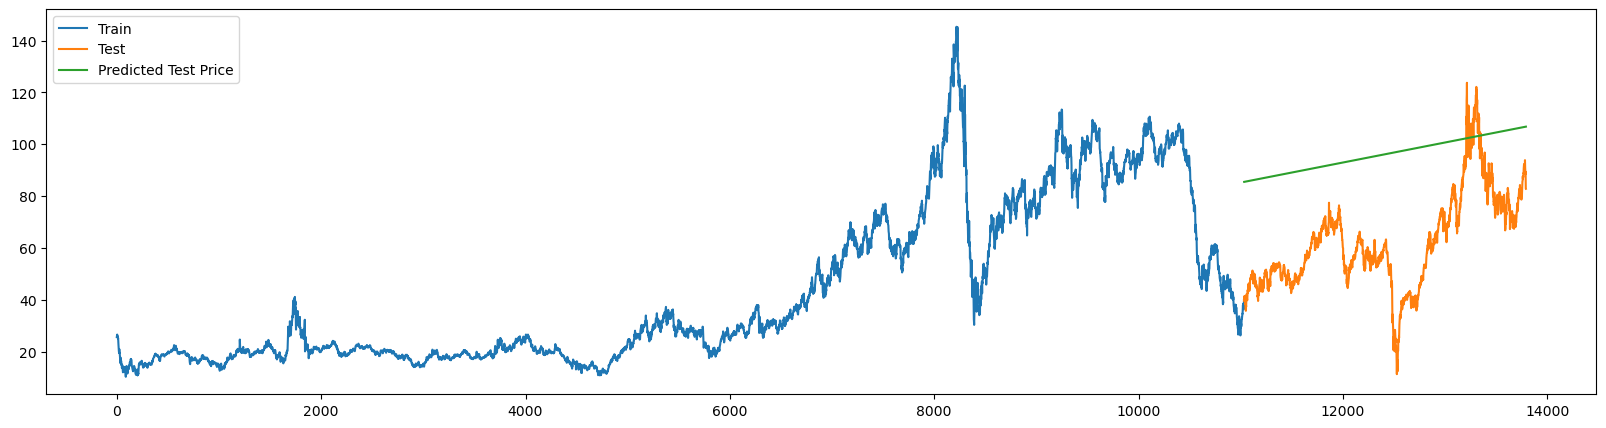

In [8]:
plt.figure(figsize=(20,5))
plt.plot(Train.Price,label = 'Train')
plt.plot(Test.Price,label = 'Test')
plt.plot(pred_linear,label = 'Predicted Test Price')
plt.legend()
plt.show()

#### Exponential Model:

In [9]:
#Exponential
Exp = smf.ols('log_price~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.round(np.sqrt(np.mean((np.array(pred_Exp)-np.array(Test['Price']))**2)),2)
print('RSME : ' , rmse_Exp)

RSME :  60.37


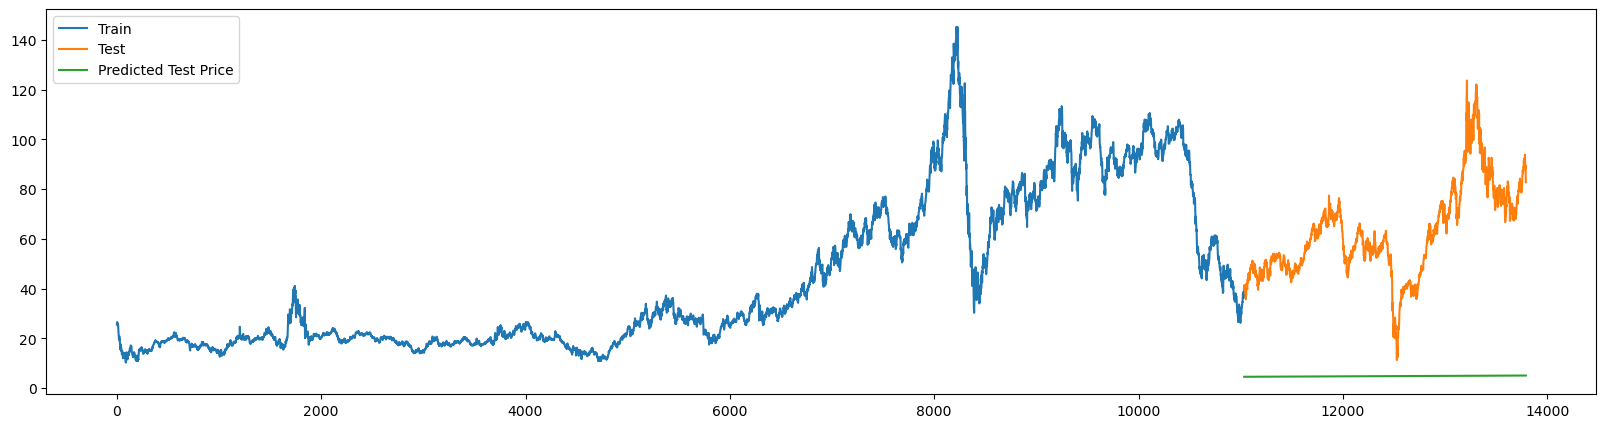

In [10]:
plt.figure(figsize=(20,5))
plt.plot(Train.Price,label = 'Train')
plt.plot(Test.Price,label = 'Test')
plt.plot(pred_Exp,label = 'Predicted Test Price')
plt.legend()
plt.show()

#### Quadratic Model:

In [11]:
Quad = smf.ols('Price~t+t_sq',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_sq"]]))
rmse_Quad = np.round(np.sqrt(np.mean((np.array(pred_Quad)-np.array(Test['Price']))**2)),2)
print('RSME : ' , rmse_Quad)

RSME :  61.05


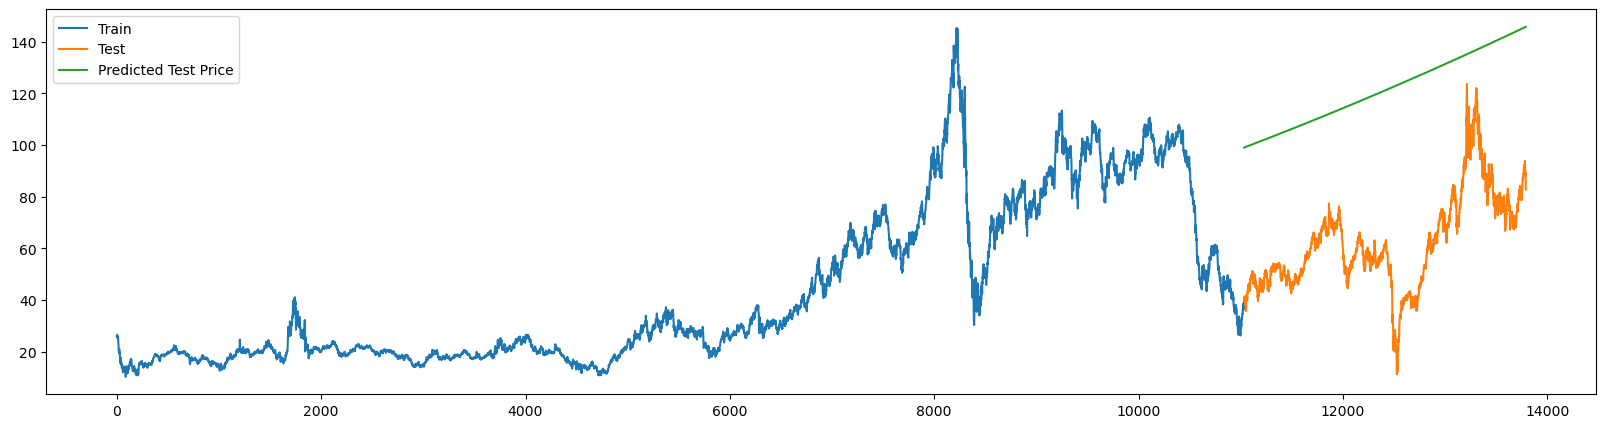

In [12]:
plt.figure(figsize=(20,5))
plt.plot(Train.Price,label = 'Train')
plt.plot(Test.Price,label = 'Test')
plt.plot(pred_Quad,label = 'Predicted Test Price')
plt.legend()
plt.show()

#### Sqrt Model:

In [13]:

sqrt_model = smf.ols('sqrt_price~t',data=Train).fit()
pred_sqrt =  pd.Series(sqrt_model.predict(pd.DataFrame(Test['t'])))
rmse_sqrt= np.round(np.sqrt(np.mean((np.array(pred_sqrt)-np.array(Test['Price']))**2)),2)
print('RSME : ' , rmse_sqrt)

RSME :  55.22


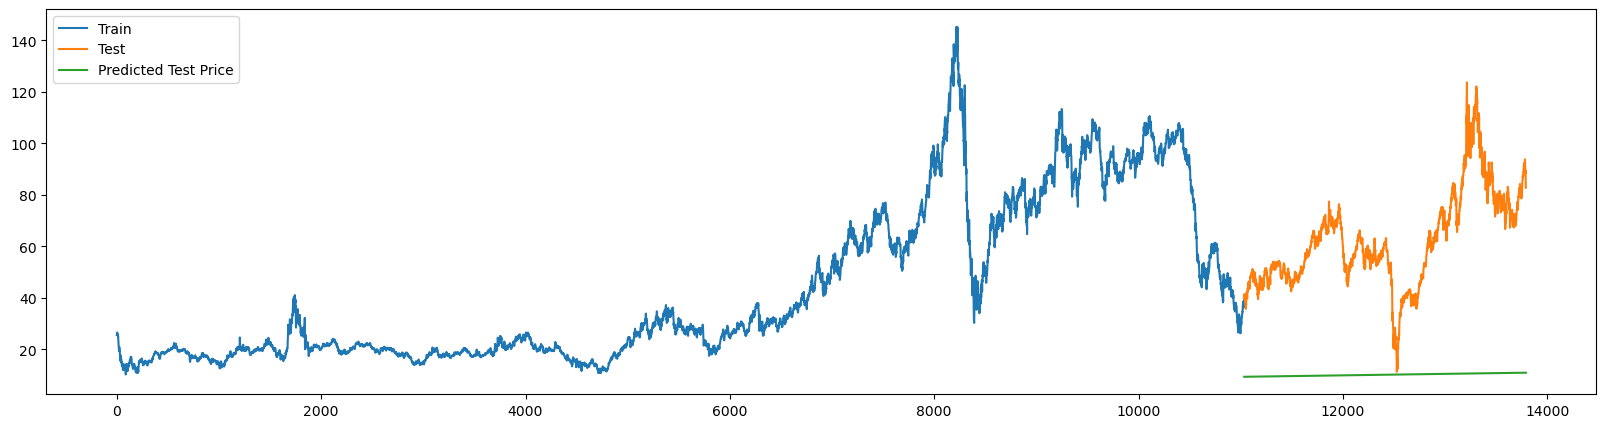

In [14]:
plt.figure(figsize=(20,5))
plt.plot(Train.Price,label = 'Train')
plt.plot(Test.Price,label = 'Test')
plt.plot(pred_sqrt,label = 'Predicted Test Price')
plt.legend()
plt.show()

#### Additive Seasonality Model:

In [15]:
add_sea = smf.ols('Price~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=Train).fit()
pred_add_sea= pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Price'])-np.array(pred_add_sea))**2))
print('RSME : ' , rmse_add_sea)

RSME :  26.85362582218483


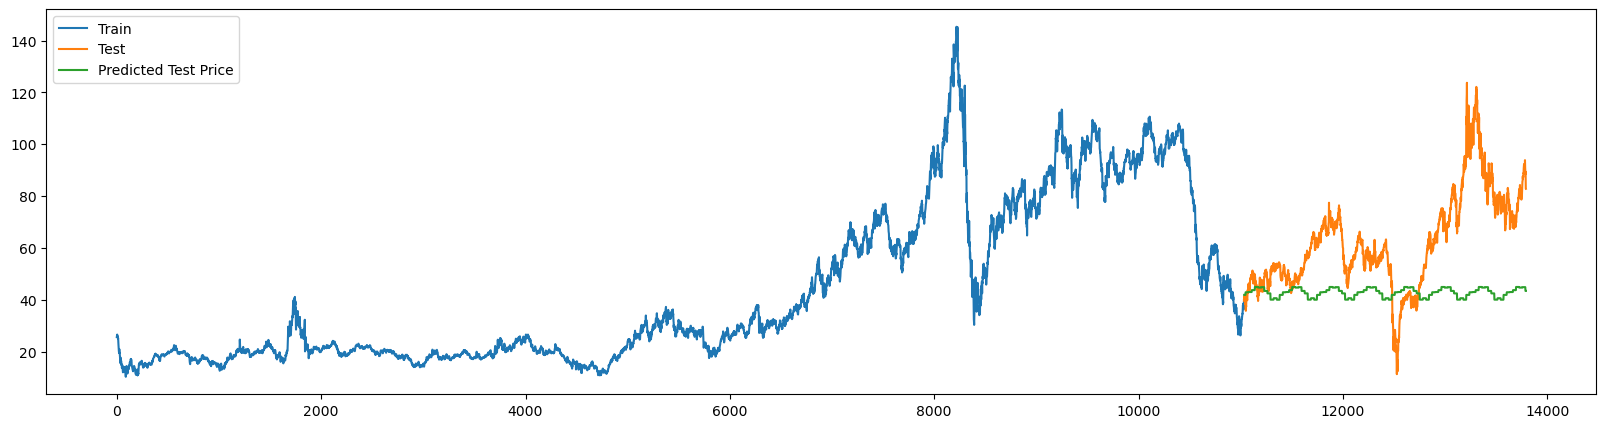

In [16]:
plt.figure(figsize=(20,5))
plt.plot(Train.Price,label = 'Train')
plt.plot(Test.Price,label = 'Test')
plt.plot(pred_add_sea,label = 'Predicted Test Price')
plt.legend()
plt.show()

#### Additive Seasonality Quadratic Model:

In [17]:
add_sea_quad = smf.ols('Price~t+t_sq+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_sq']]))
rmse_add_sea_quad =np.sqrt(np.mean((np.array(Test['Price'])-np.array(pred_add_sea_quad))**2))
print('RSME : ' , rmse_add_sea_quad)

RSME :  61.38201613071159


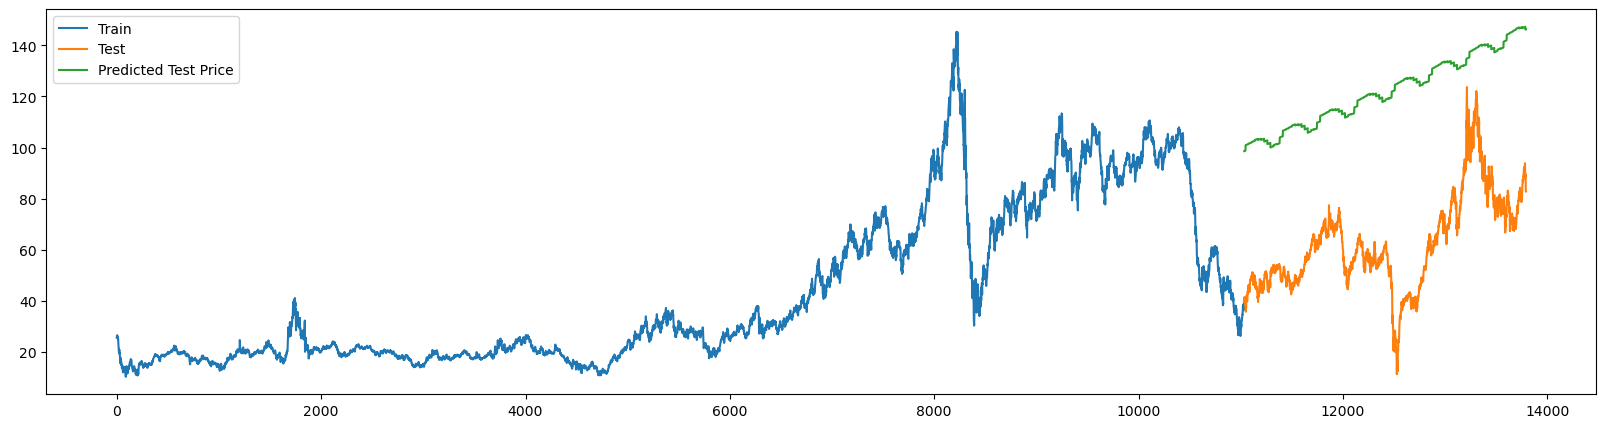

In [18]:
plt.figure(figsize=(20,5))
plt.plot(Train.Price,label = 'Train')
plt.plot(Test.Price,label = 'Test')
plt.plot(pred_add_sea_quad,label = 'Predicted Test Price')
plt.legend()
plt.show()

### Data Driven Techniques:

In [19]:
# Preparing oil df for modeling :
oil = oil.iloc[:,[0,1]]
oil.set_index('Date',inplace=True,drop=True)
oil.head()

Price
Date                 
1986-01-02  25.560000
1986-01-03  26.000000
1986-01-04  26.176667
1986-01-05  26.353333
1986-01-06  26.530000

In [20]:
# Train Test Split :   
Train = oil.head(11034)
Test = oil.tail(2758)

#### Simple Exponential Smoothing Model:

Simple exponential smoothing is a method of forecasting time series data that does not have a trend or seasonality. It only considers the level or the average of the data.

In [21]:
#Finding best Alpha:
for i in np.round(np.arange(0.1,1,0.1),2):
    ses_model = SimpleExpSmoothing(Train).fit(smoothing_level=i,optimized=True)
    test_pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
    test_rmse_ses = round(np.sqrt(mean_squared_error(test_pred_ses,Test)),5)
    print("RSME for alpha = {} is {}".format(i,test_rmse_ses))

C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

RSME for alpha = 0.1 is 31.36211
RSME for alpha = 0.2 is 30.30264
RSME for alpha = 0.3 is 29.94113
RSME for alpha = 0.4 is 29.71484
RSME for alpha = 0.5 is 29.54108
RSME for alpha = 0.6 is 29.41258
RSME for alpha = 0.7 is 29.33121
RSME for alpha = 0.8 is 29.29653
RSME for alpha = 0.9 is 29.30462


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [22]:
# Creating SES model with alpha = 0.8

ses_model = SimpleExpSmoothing(Train).fit(smoothing_level=0.8,optimized=True)
test_pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
test_rmse_ses = np.sqrt(mean_squared_error(test_pred_ses,Test))
print("RSME for alpha = {} is {}".format(0.8,test_rmse_ses))

RSME for alpha = 0.8 is 29.296534952609637


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


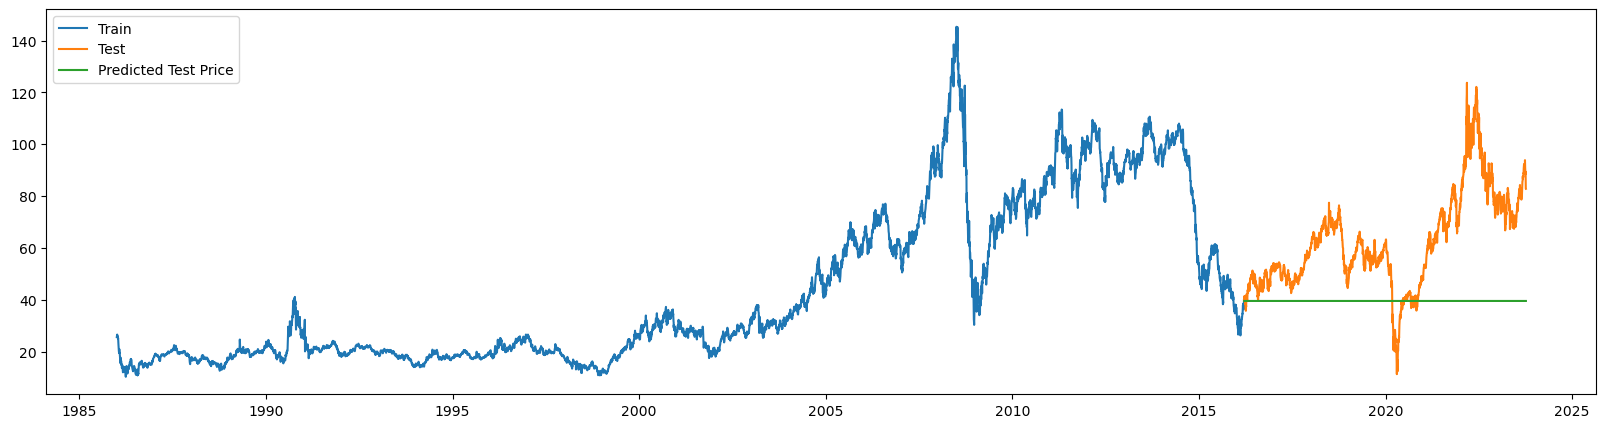

In [23]:
plt.figure(figsize=(20,5))
plt.plot(Train,label = 'Train')
plt.plot(Test,label = 'Test')
plt.plot(test_pred_ses,label = 'Predicted Test Price')
plt.legend()
plt.show()

#### Holt’s Double Exponential Model:

In [24]:
for i in np.round(np.arange(0.1,1,0.1),2):
    for j in np.round(np.arange(0.1,1,0.1),2):
        dexp_model  = Holt(Train).fit(smoothing_level=i,smoothing_trend=j,optimized=True)
        test_pred_dexp = dexp_model.predict(start = Test.index[0],end = Test.index[-1])
        test_rmse_dexp = round(np.sqrt(mean_squared_error(test_pred_dexp,Test)),4)
        print("RSME for α = {} and β = {} is {}".format(i,j,test_rmse_dexp))

C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.1 and β = 0.1 is 563.8115
RSME for α = 0.1 and β = 0.2 is 503.0821


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.1 and β = 0.3 is 156.6327
RSME for α = 0.1 and β = 0.4 is 177.3048


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.1 and β = 0.5 is 15.5881
RSME for α = 0.1 and β = 0.6 is 230.4644


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.1 and β = 0.7 is 203.1483
RSME for α = 0.1 and β = 0.8 is 17.9962


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.1 and β = 0.9 is 236.9683
RSME for α = 0.2 and β = 0.1 is 432.3073


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.2 and β = 0.2 is 250.3098


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.2 and β = 0.3 is 177.1817


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.2 and β = 0.4 is 163.9542
RSME for α = 0.2 and β = 0.5 is 167.1416


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.2 and β = 0.6 is 261.5106


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.2 and β = 0.7 is 437.6061


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.2 and β = 0.8 is 648.4269


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.2 and β = 0.9 is 867.5006
RSME for α = 0.3 and β = 0.1 is 396.7076


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.3 and β = 0.2 is 305.8226


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.3 and β = 0.3 is 315.4835
RSME for α = 0.3 and β = 0.4 is 419.7534


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.3 and β = 0.5 is 607.905
RSME for α = 0.3 and β = 0.6 is 845.9374


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.3 and β = 0.7 is 1102.5456


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.3 and β = 0.8 is 1358.9377
RSME for α = 0.3 and β = 0.9 is 1599.2454


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.4 and β = 0.1 is 406.1752


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.4 and β = 0.2 is 392.1176


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.4 and β = 0.3 is 490.9858
RSME for α = 0.4 and β = 0.4 is 686.7581


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.4 and β = 0.5 is 934.4669
RSME for α = 0.4 and β = 0.6 is 1193.5615


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.4 and β = 0.7 is 1436.6065


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.4 and β = 0.8 is 1649.0787
RSME for α = 0.4 and β = 0.9 is 1828.9017


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.5 and β = 0.1 is 426.5871


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.5 and β = 0.2 is 471.0642


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.5 and β = 0.3 is 624.3683


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.5 and β = 0.4 is 850.5701
RSME for α = 0.5 and β = 0.5 is 1095.3258


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.5 and β = 0.6 is 1322.2046


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.5 and β = 0.7 is 1513.3346


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.5 and β = 0.8 is 1662.9083


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.5 and β = 0.9 is 1769.0661


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.6 and β = 0.1 is 444.0301


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.6 and β = 0.2 is 523.6701


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.6 and β = 0.3 is 695.3808


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.6 and β = 0.4 is 911.0724
RSME for α = 0.6 and β = 0.5 is 1116.407


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.6 and β = 0.6 is 1280.6041


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.6 and β = 0.7 is 1389.4334


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.6 and β = 0.8 is 1436.1412


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.6 and β = 0.9 is 1416.4168
RSME for α = 0.7 and β = 0.1 is 452.9364


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.7 and β = 0.2 is 545.241


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.7 and β = 0.3 is 706.7662


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.7 and β = 0.4 is 883.4263


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.7 and β = 0.5 is 1023.3981


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.7 and β = 0.6 is 1099.7329


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.7 and β = 0.7 is 1100.5055


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.7 and β = 0.8 is 1021.4104


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.7 and β = 0.9 is 862.9698


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.8 and β = 0.1 is 451.8019


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.8 and β = 0.2 is 537.7536


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.8 and β = 0.3 is 667.9399


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.8 and β = 0.4 is 786.3235


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.8 and β = 0.5 is 845.0378


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.8 and β = 0.6 is 822.0468
RSME for α = 0.8 and β = 0.7 is 710.7625


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.8 and β = 0.8 is 513.5186


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.8 and β = 0.9 is 238.6026


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.9 and β = 0.1 is 441.2523


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.9 and β = 0.2 is 506.3042


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.9 and β = 0.3 is 591.2925
RSME for α = 0.9 and β = 0.4 is 641.499


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.9 and β = 0.5 is 614.9845
RSME for α = 0.9 and β = 0.6 is 496.7373


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.9 and β = 0.7 is 287.7738
RSME for α = 0.9 and β = 0.8 is 14.7458


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RSME for α = 0.9 and β = 0.9 is 358.5424


In [25]:
#Creating double exponential model with α = 0.9 and β = 0.8: 
dexp_model  = Holt(Train).fit(smoothing_level=0.9,smoothing_trend=0.8,optimized=True)
test_pred_dexp = dexp_model.predict(start = Test.index[0],end = Test.index[-1])
test_rmse_dexp = np.sqrt(mean_squared_error(test_pred_dexp,Test))
print("RSME for α = {} and β = {} is {}".format(0.9,0.8,test_rmse_dexp))

RSME for α = 0.9 and β = 0.8 is 14.745799374703656


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


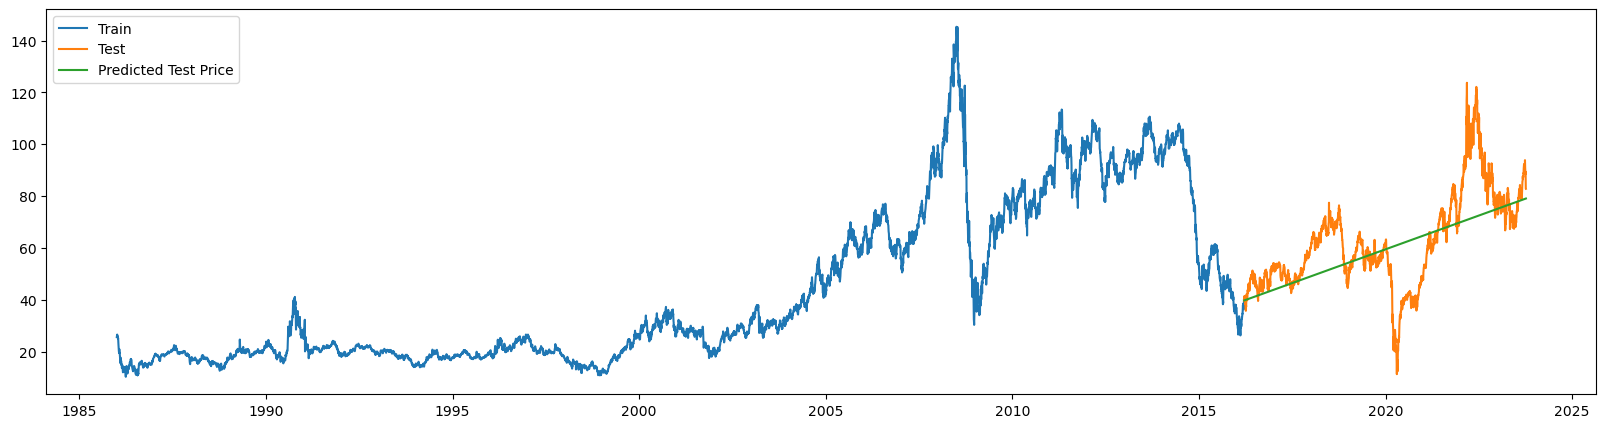

In [26]:
plt.figure(figsize=(20,5))
plt.plot(Train,label = 'Train')
plt.plot(Test,label = 'Test')
plt.plot(test_pred_dexp,label = 'Predicted Test Price')
plt.legend()
plt.show()

#### Holt’s Winter Exponential Model:

In [27]:
#Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)

texp_add_model  = ExponentialSmoothing(Train,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.predict(start = Test.index[0],end = Test.index[-1])
test_rmse_ad_texp = np.sqrt(mean_squared_error(test_pred_ad_texp,Test))
print('Test Root Mean Squared Error  = {}'.format(test_rmse_ad_texp))


C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Test Root Mean Squared Error  = 27.618731389360363


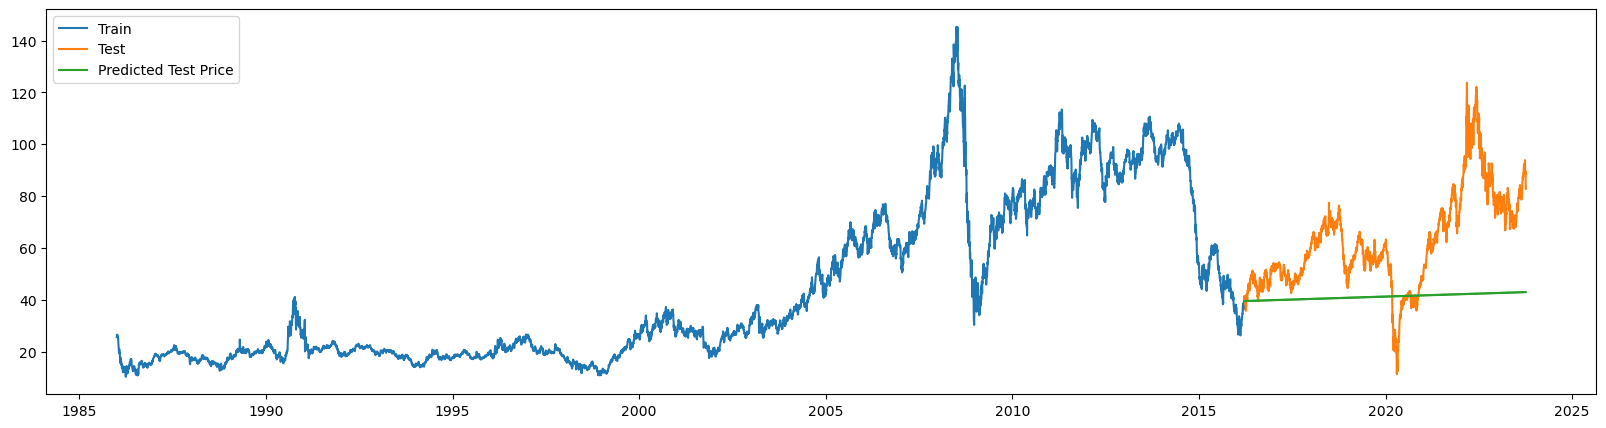

In [28]:
plt.figure(figsize=(20,5))
plt.plot(Train,label = 'Train')
plt.plot(Test,label = 'Test')
plt.plot(test_pred_ad_texp,label = 'Predicted Test Price')
plt.legend()
plt.show()

### Stationarity:

#### Statistical Tests To Check Stationarity:

##### Dickey Fuller Test :

In [29]:
#Null Hypothesis  H0: Data is Non-Stationary
#Alternate Hypothesis H1: Data is Stationary

dftest = adfuller(oil, autolag='AIC')  #The autolag=‘AIC’ parameter in the Dickey-Fuller test is a method to automatically determine the optimal number of lags to include in the test.
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

Test Statistic                    -2.191695
p-value                            0.209274
#Lags Used                        41.000000
Number of Observations Used    13750.000000
dtype: float64

##### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test :


In [30]:
#Null Hypothesis  H0: Data is Stationary
#Alternate Hypothesis H1: Data is Non-Stationary

kpsstest = kpss(oil,regression='c')
kpssoutput = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
kpssoutput

C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Test Statistic    11.877412
p-value            0.010000
#Lags Used        71.000000
dtype: float64

#### Converting non-stationary data to stationary data:

In [31]:
#SQRT Transform:
sqrtdf = oil.copy()
sqrtdf['Price'] = np.sqrt(sqrtdf['Price'])
dftest = adfuller(sqrtdf, autolag='AIC')  #The autolag=‘AIC’ parameter in the Dickey-Fuller test is a method to automatically determine the optimal number of lags to include in the test.
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput
# H0 : Data is non-stationary

Test Statistic                    -1.920353
p-value                            0.322548
#Lags Used                        29.000000
Number of Observations Used    13762.000000
dtype: float64

In [32]:
#Log Transform:
logdf = oil.copy()
logdf['Price'] = np.log(logdf['Price'])
dftest = adfuller(logdf, autolag='AIC')  #The autolag=‘AIC’ parameter in the Dickey-Fuller test is a method to automatically determine the optimal number of lags to include in the test.
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput
# H0 : Data is non-stationary

Test Statistic                    -1.885510
p-value                            0.338908
#Lags Used                        29.000000
Number of Observations Used    13762.000000
dtype: float64

In [33]:
#Diffrencing Transform:
#Differencing: This method subtracts the current value from the previous value of the series, resulting in a new series that has no trend or seasonality.
diff = oil.copy()
diff['Price'] = diff['Price'] - diff['Price'].shift()
dftest = adfuller(diff.dropna(), autolag='AIC')  #The autolag=‘AIC’ parameter in the Dickey-Fuller test is a method to automatically determine the optimal number of lags to include in the test.
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput
# H0 : Data is Stationary

Test Statistic                -1.664231e+01
p-value                        1.630658e-29
#Lags Used                     4.000000e+01
Number of Observations Used    1.375000e+04
dtype: float64

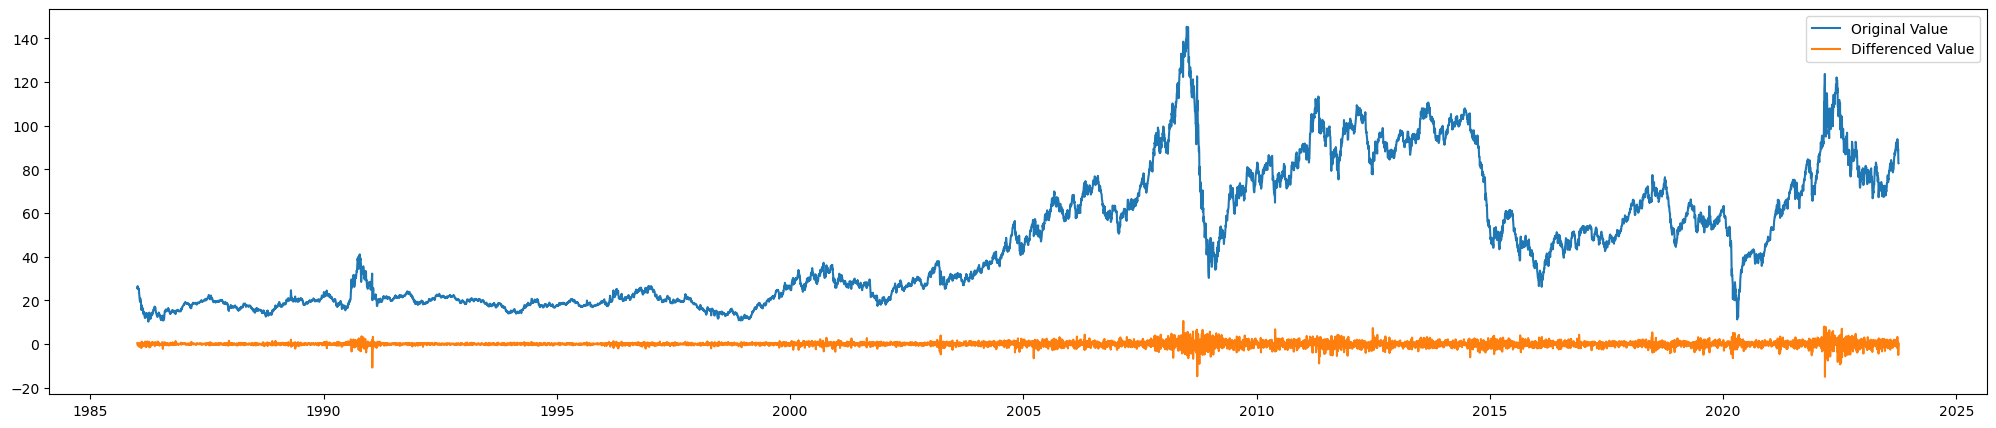

In [34]:
plt.figure(figsize=(25,5))
plt.plot(oil,label = 'Original Value')
plt.plot(diff,label = 'Differenced Value')
plt.legend()
plt.show()

In [35]:
# We have made the data Stationary:
diff.dropna(inplace=True)
diff.head()

Price
Date                
1986-01-03  0.440000
1986-01-04  0.176667
1986-01-05  0.176667
1986-01-06  0.176667
1986-01-07 -0.680000

#### Auto Regressive Integrated Moving Average model:

In [36]:
#Train Test split in (80:20 ratio)
Train = oil.head(round(oil.shape[0]*.8))
Test = oil.tail(oil.shape[0] - round(oil.shape[0]*.8))

#### Seasonal Auto-Regressive Integrated Moving Average model:

In [37]:
model = SARIMAX(Train,order =(1,0,0) ,seasonal_order =(2,1,0,12))
result = model.fit()
result.summary()

C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Anup0\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Price   No. Observations:                11034
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood              -15628.056
Date:                            Wed, 08 Nov 2023   AIC                          31264.112
Time:                                    19:39:26   BIC                          31293.342
Sample:                                01-02-1986   HQIC                         31273.959
                                     - 03-18-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9676      0.001    834.320      0.000       0.965       0.970
ar.S.L12      -0.6604      0.004   -147.768      0.000      -0.669      -0.652
ar.S.L24      -0.3113      0.004    -74.298      0.000      -0.320      -0.303
sigma2         0.9972      0.005    208.549      0.000       0.988       1.007
===================================================================================
Ljung-Box (L1) (Q):                  11.25   Jarque-Bera (JB):             96749.69
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.33   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
start = len(Train)
end = len(Train)+len(Test)-1

# Predictions for test data:
predictions = result.predict(start,end,typ = 'levels').rename('Predictions')


test_rmse_sarimax = np.sqrt(mean_squared_error(Test,predictions))
print('RSME : ' , test_rmse_sarimax)

RSME :  25.25195429921016


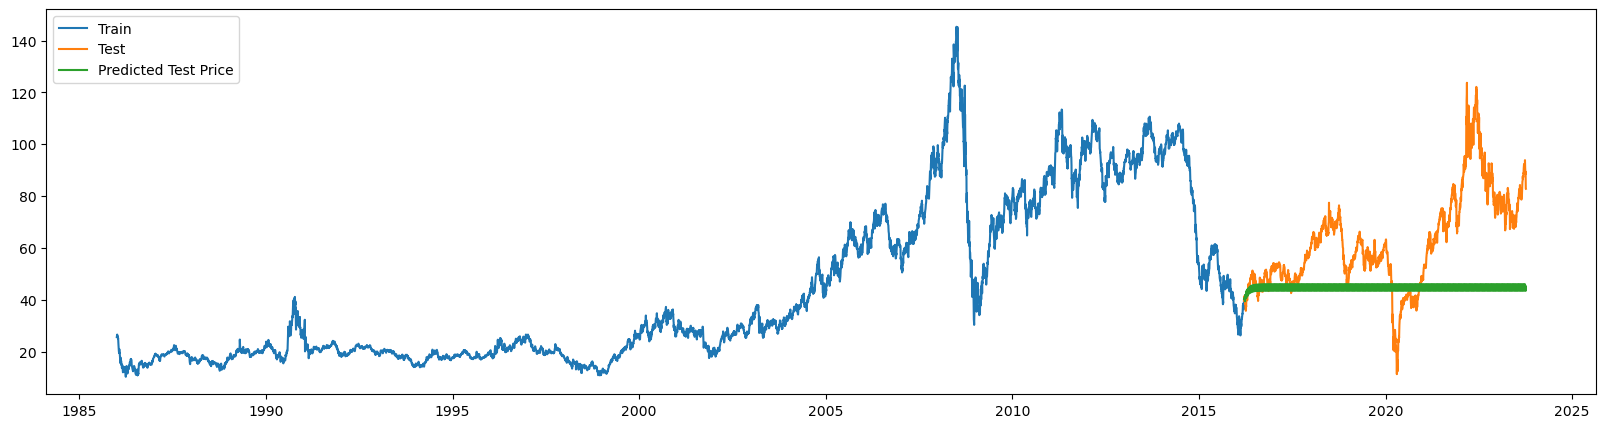

In [39]:
plt.figure(figsize=(20,5))
plt.plot(Train,label = 'Train')
plt.plot(Test,label = 'Test')
plt.plot(predictions,label = 'Predicted Test Price')
plt.legend()
plt.show()

#### Long Short Term Memory (LSTM) Model:

In [40]:
#Preparing independent and dependent features: 
def prep_data(series_data, n_features):
    X,y = [],[]
    for i in range(len(series_data)):
        #find end of this pattern:
        end_ix = i + n_features
        #check if we are beyond the sequence:
        if end_ix > len(series_data)-1:
            break
        #gather input and output parts of the pattern
        seq_x,seq_y = series_data[i:end_ix],series_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X),np.array(y)

In [41]:
#Define the input sequenece:

data = np.array(oil.Price)
n_features =5
X,y = prep_data(data,n_features)
print(X)
print(y)

[[25.56       26.         26.17666667 26.35333333 26.53      ]
 [26.         26.17666667 26.35333333 26.53       25.85      ]
 [26.17666667 26.35333333 26.53       25.85       25.87      ]
 ...
 [90.79       90.01666667 89.24333333 88.47       89.39      ]
 [90.01666667 89.24333333 88.47       89.39       84.37      ]
 [89.24333333 88.47       89.39       84.37       82.89      ]]
[25.85 25.87 26.03 ... 84.37 82.89 82.79]


In [42]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [43]:
#Train Test split = 80:20 ratio
X_train = X[:11030]
X_test = X[11030:]
y_train = y[:11030]
y_test = y[11030:]

In [44]:
# create and fit the LSTM network regressor = Sequential() 
regressor = Sequential()

regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.1))


regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 20, batch_size = 32,validation_data=(X_test, y_test),shuffle=False)

Epoch 1/20
345/345 [==============================] - 10s 13ms/step - loss: 1079.1392 - val_loss: 972.2476
Epoch 2/20
345/345 [==============================] - 3s 10ms/step - loss: 936.2730 - val_loss: 730.8903
Epoch 3/20
345/345 [==============================] - 4s 13ms/step - loss: 991.6266 - val_loss: 675.2273
Epoch 4/20
345/345 [==============================] - 4s 13ms/step - loss: 1050.9175 - val_loss: 736.7955
Epoch 5/20
345/345 [==============================] - 4s 13ms/step - loss: 1098.0012 - val_loss: 997.2384
Epoch 6/20
345/345 [==============================] - 4s 13ms/step - loss: 964.1029 - val_loss: 847.2608
Epoch 7/20
345/345 [==============================] - 4s 13ms/step - loss: 658.3468 - val_loss: 351.1592
Epoch 8/20
345/345 [==============================] - 4s 12ms/step - loss: 809.8707 - val_loss: 427.3949
Epoch 9/20
345/345 [==============================] - 4s 12ms/step - loss: 698.2043 - val_loss: 384.1552
Epoch 10/20
345/345 [==============================

In [45]:
test_predict = regressor.predict(X_test)

87/87 [==============================] - 2s 4ms/step


#inverse_transform:
test_predict = (test_predict)**2
y_test = (y_test)**2


In [46]:
test_rmse_lstm = np.sqrt(mean_squared_error(y_test, test_predict[:,0]))
print('RSME: ',test_rmse_lstm)

RSME:  5.111434462639556


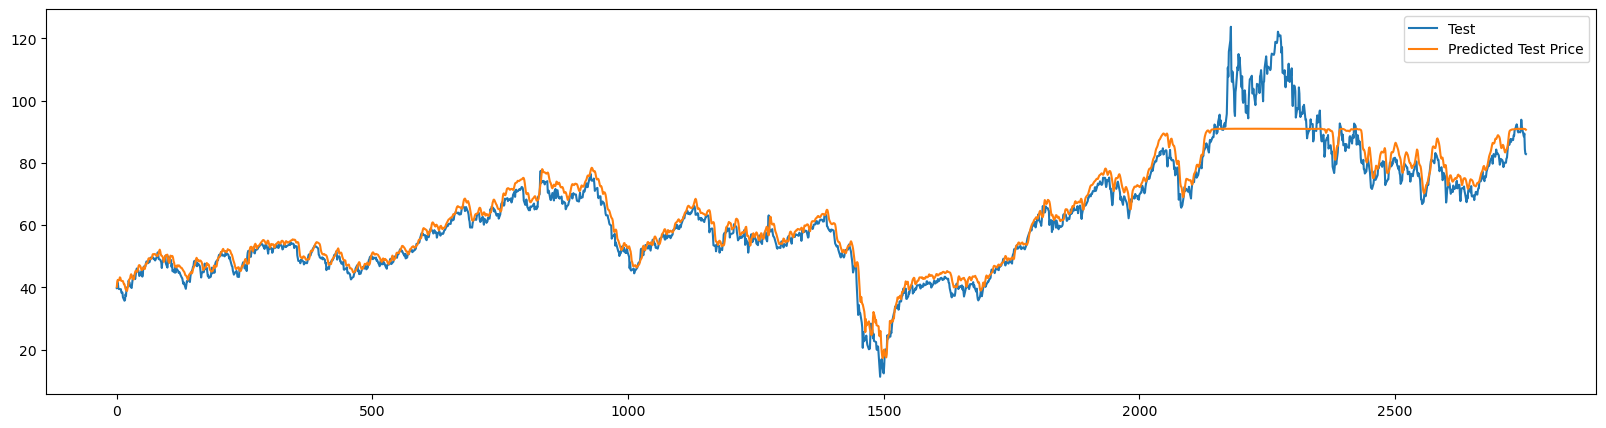

In [47]:
plt.figure(figsize=(20,5))
plt.plot(y_test,label = 'Test')
plt.plot(test_predict,label = 'Predicted Test Price')
plt.legend()
plt.show()

### Comparing the results:

In [48]:
data = {"MODEL":pd.Series(["Linear","Exponential","Quadratic","SquareRoot","Additive Seasonality",
                           "Additive Seasonality Quadratic","Simple Exponential Smoothing","Double Exponential Smoothing",
                          "Holt’s Winter Exponential Model","SARIMAX","LSTM"]),
        "RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_sqrt,rmse_add_sea,rmse_add_sea_quad,test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,
                                test_rmse_sarimax,test_rmse_lstm])}
RSME_TABLE=pd.DataFrame(data)
RSME_TABLE.sort_values(['RMSE_Values'],ascending=True)

MODEL  RMSE_Values
10                             LSTM     5.111434
7      Double Exponential Smoothing    14.745799
9                           SARIMAX    25.251954
4              Additive Seasonality    26.853626
8   Holt’s Winter Exponential Model    27.618731
6      Simple Exponential Smoothing    29.296535
0                            Linear    37.150000
3                        SquareRoot    55.220000
1                       Exponential    60.370000
2                         Quadratic    61.050000
5    Additive Seasonality Quadratic    61.382016

In [49]:
import plotly.express as px
fig = px.bar(RSME_TABLE, x="MODEL", y="RMSE_Values", color="MODEL")
fig.update_layout(xaxis={"categoryorder":"total ascending"}) 
fig.show()

### Insights drawn from the analysis:

### Forecasting Using LSTM	Model:

In [50]:
# Prediction for next 365 days
x_input = np.array(oil.Price.tail(5))
temp_input=list(x_input)
forecast=[]
i=1
while(i<366):
    arr_x = np.array(temp_input[-5:])
    arr_x = arr_x.reshape(1,5,1)
    f = regressor.predict(arr_x,verbose=False)
    temp_input.append(f[0][0])
    rf = np.round(f[0][0])
    print("{} day forecast {}".format(i,rf))
    forecast.append(rf)
    i=i+1

1 day forecast 90.0
2 day forecast 90.0
3 day forecast 90.0
4 day forecast 91.0
5 day forecast 91.0
6 day forecast 91.0
7 day forecast 91.0
8 day forecast 91.0
9 day forecast 91.0
10 day forecast 91.0
11 day forecast 91.0
12 day forecast 91.0
13 day forecast 91.0
14 day forecast 91.0
15 day forecast 91.0
16 day forecast 91.0
17 day forecast 91.0
18 day forecast 91.0
19 day forecast 91.0
20 day forecast 91.0
21 day forecast 91.0
22 day forecast 91.0
23 day forecast 91.0
24 day forecast 91.0
25 day forecast 91.0
26 day forecast 91.0
27 day forecast 91.0
28 day forecast 91.0
29 day forecast 91.0
30 day forecast 91.0
31 day forecast 91.0
32 day forecast 91.0
33 day forecast 91.0
34 day forecast 91.0
35 day forecast 91.0
36 day forecast 91.0
37 day forecast 91.0
38 day forecast 91.0
39 day forecast 91.0
40 day forecast 91.0
41 day forecast 91.0
42 day forecast 91.0
43 day forecast 91.0
44 day forecast 91.0
45 day forecast 91.0
46 day forecast 91.0
47 day forecast 91.0
48 day forecast 91.0
4

ValueError: x and y must have same first dimension, but have shapes (364,) and (365,)

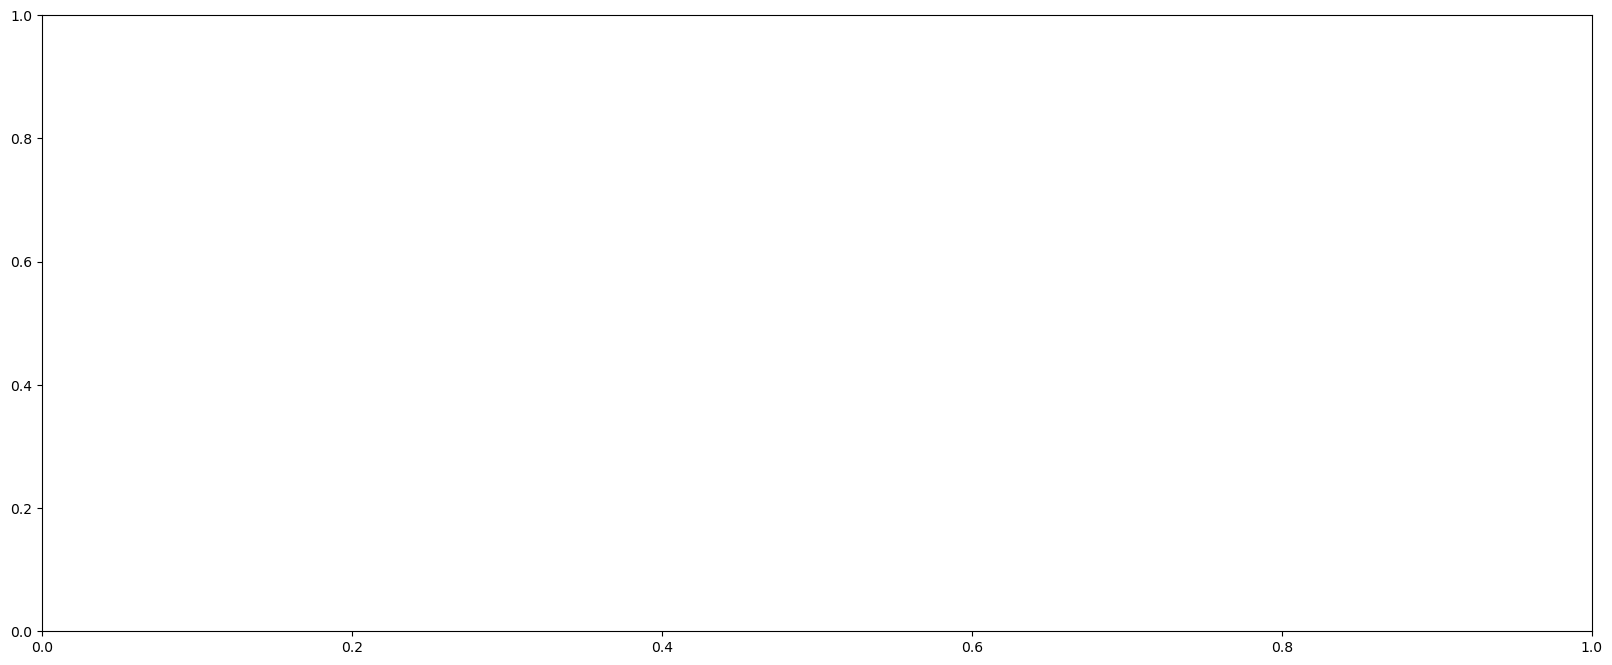

In [51]:
day_new=np.arange(1,365)
plt.plot(day_new,forecast)
plt.show()

### Forecasting Using Double Exponential Model:

In [ ]:
# Prediction for next 365 days
#Creating double exponential model with α = 0.9 and β = 0.8: 
dexp_model  = Holt(oil).fit(smoothing_level=0.9,smoothing_trend=0.8,optimized=True)
f_dexp = dexp_model.forecast(365)
plt.figure(figsize=(10,5))
plt.plot(oil,label = 'Actual')
plt.plot(f_dexp,label = 'Forecast')
plt.legend()
plt.show()

### Forecasting Using Triple Exponential Smoothing Model:

In [ ]:
# Prediction for next 365 days
#Creating double exponential model with α = 0.9 and β = 0.8: 
texp_add_model  = ExponentialSmoothing(oil,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
f_texp = texp_add_model.forecast(365)
plt.figure(figsize=(10,5))
plt.plot(oil,label = 'Actual')
plt.plot(f_dexp,label = 'Forecast')
plt.legend()
plt.show()


### Forecasting Using Sarimax Model:

In [ ]:
model = SARIMAX(oil,order =(1,0,0) ,seasonal_order =(2,1,0,12))
result = model.fit()
forecast = result.forecast(365)
forecast.head()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(oil,label = 'Actual')
plt.plot(forecast,label = 'Forecast')
plt.legend()
plt.show()

### Business Insights:

We can say that the crude oil prices are likely to go down or stay stable in next 1 year.